# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="../../images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Backfill Features to the Feature Store</span>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/advanced_tutorials/credit_scores/1_backfill_feature_groups.ipynb)

## 🗒️ This notebook is divided into the following sections:
1. Fetch historical data
2. Connect to the Hopsworks feature store
3. Create feature groups and insert them to the feature store
4. Data Visualization

![tutorial-flow](../../images/01_featuregroups.png)

In [1]:
# !pip uninstall hopsworks -y
# !pip install -U hopsworks --quiet

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *

## <span style="color:#ff5f27;"> 💽 Loading the Data </span>

#### <span style="color:#ff5f27;">⛳️ Application Train dataset</span>

The main training dataset contains information about each loan application at Home Credit. Every loan has its own row and is identified by the feature **SK_ID_CURR**. This dataset has binary target indicating if the loan was repaid(0) or not(1).

In [2]:
application_org = pd.read_csv("https://repo.hops.works/dev/davit/credit_scores/applications.csv")
application_org.head()

0

#### <span style="color:#ff5f27;">⛳️ Bureau Balance dataset</span>

Dataset contains monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

In [3]:
bureau_balance = pd.read_csv('https://repo.hops.works/dev/davit/credit_scores/bureau_balances.csv')

bureau_balance.head()

0

#### <span style="color:#ff5f27;">⛳️ Bureau Dataset</span>

Dataset contains data about client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

In [4]:
bureau = pd.read_csv('https://repo.hops.works/dev/davit/credit_scores/bureaus.csv')

bureau.head()

0

#### <span style="color:#ff5f27;">⛳️ Credit Card Balance Dataset</span>

Dataset contains monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

In [5]:
credit_card_balance = pd.read_csv('https://repo.hops.works/dev/davit/credit_scores/credit_card_balances.csv')

credit_card_balance.head()

0

#### <span style="color:#ff5f27;">⛳️ Installments Payments Dataset</span>

Dataset contains payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

In [6]:
installments_payments = pd.read_csv('https://repo.hops.works/dev/davit/credit_scores/installment_payments.csv')

installments_payments.head()

0

#### <span style="color:#ff5f27;">⛳️ POS (point of sales) and Cash Loans Balance Dataset</span>

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample

In [7]:
pos_cash_balance = pd.read_csv('https://repo.hops.works/dev/davit/credit_scores/pos_cash_balances.csv')

pos_cash_balance.head()

0

#### <span style="color:#ff5f27;">⛳️ Previous Application Dataset</span>

All previous applications for Home Credit loans of clients who have loans in our sample.

There is one row for each previous application related to loans in our data sample.

In [8]:
previous_application = pd.read_csv('https://repo.hops.works/dev/davit/credit_scores/previous_applications.csv')

previous_application.head()

0

---

## <span style="color:#ff5f27;"> 🛠️ Feature Engineering </span>

#### <span style="color:#ff5f27;"> ⛳️ Dataset with amount of previous loans</span>

In [10]:
previous_loan_counts = bureau.groupby('sk_id_curr', as_index=False)['sk_id_bureau'].count().rename(columns = {'sk_id_bureau': 'previous_loan_counts'})

previous_loan_counts.head()

,sk_id_curr,previous_loan_counts
0,100082,10
1,100083,2
2,100128,9
3,100157,5
4,100414,10


---

## <span style="color:#ff5f27;">👨🏻‍⚖️ Dealing with missing values</span>

In [11]:
application = remove_nans(application_org)
bureau = remove_nans(bureau)
credit_card_balance.dropna(inplace = True)
installments_payments.dropna(inplace = True)
pos_cash_balance.dropna(inplace = True)
previous_application = remove_nans(previous_application)

---
## <span style="color:#ff5f27;">🔬 🧬 Subsampling Data</span>

Our datasets have a lot of data. So we are going to subsample them in order to save our time.



In [12]:
applications_sample = get_subsample(application)
bureau_balance_sample = get_subsample(bureau_balance)
bureau_sample = get_subsample(bureau)
credit_card_balance_sample = get_subsample(credit_card_balance)
installments_payments_sample = get_subsample(installments_payments)
pos_cash_balance_sample = get_subsample(pos_cash_balance)
previous_application_sample = get_subsample(previous_application)

## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [13]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.


In [14]:
print(f'Feature Store Name: {fs.name}')
print(f'Feature Store Description: {fs.description}')

Feature Store Name: dowlingj_featurestore
Feature Store Description: Featurestore database for project: dowlingj


---

## <span style="color:#ff5f27;"> 🪄 Creating Feature Groups </span>

A `Feature Groups` is a logical grouping of features, and experience has shown, that this grouping generally originates from the features being derived from the same data source. The `Feature Group` lets you save metadata along features.

Generally, the features in a feature group are engineered together in an ingestion job. However, it is possible to have additional jobs to append features to an existing feature group. Furthermore, `Feature Groups` provide a way of defining a namespace for features, such that you can define features with the same name multiple times, but uniquely identified by the group they are contained in.

> It is important to note that `Feature Groups` are not groupings of features for immediate training of Machine Learning models. Instead, to ensure reusability of features, it is possible to combine features from any number of groups into **Feature View**.

### <span style="color:#ff5f27;">⛳️Creating Applications Feature Group </span>

In [15]:
application.columns = [col_name.lower() for col_name in application.columns]

application_fg = fs.get_or_create_feature_group(
    name = 'application',
    version = 1,
    primary_key = ['sk_id_curr'],
    online_enabled = False
)

application_fg.insert(applications_sample, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/21941


Uploading Dataframe: 0.00% |          | Rows 0/498 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/application_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fcda9ee3550>, None)

#### <span style="color:#ff5f27;"> ⛳️ Bureau Balance Feature Group</span>

In [16]:
bureau_balance.columns = [col_name.lower() for col_name in bureau_balance.columns]

bureau_balance_fg = fs.get_or_create_feature_group(
    name = 'bureau_balance',
    version = 1,
    primary_key = ['sk_id_bureau'],
    online_enabled = False
)

bureau_balance_fg.insert(bureau_balance_sample, write_options={"wait_for_job" : False})

Uploading Dataframe: 0.00% |          | Rows 0/2067 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/bureau_balance_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fcdb3da3940>, None)

#### <span style="color:#ff5f27;"> ⛳️ Bureau Feature Group</span>

In [17]:
bureau.columns = [col_name.lower() for col_name in bureau.columns]

bureau_fg = fs.get_or_create_feature_group(
    name = 'bureau',
    version = 1,
    primary_key = ['sk_id_curr','sk_id_bureau'],
    online_enabled = False
)

bureau_fg.insert(bureau_sample, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/21942


Uploading Dataframe: 0.00% |          | Rows 0/3187 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/bureau_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fcda86b5d90>, None)

#### <span style="color:#ff5f27;"> ⛳️ Previous Application Feature Group</span>

In [41]:
previous_application.columns = [col_name.lower() for col_name in previous_application.columns]

previous_application_fg = fs.get_or_create_feature_group(
    name = 'previous_application',
    version = 1,
    primary_key = ['sk_id_prev','sk_id_curr'],
    online_enabled = False
)

previous_application_fg.insert(previous_application_sample, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/21948


Uploading Dataframe: 0.00% |          | Rows 0/5228 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/previous_application_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fcda3280c10>, None)

In [40]:
previous_application_sample

,sk_id_prev,sk_id_curr,name_contract_type,amt_application,amt_credit,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,name_cash_loan_purpose,...,code_reject_reason,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,name_yield_group,product_combination
0,1205406,240033,Consumer loans,67860.0,75024.0,MONDAY,10,Y,1,XAP,...,XAP,Refreshed,Consumer Electronics,POS,XNA,Regional / Local,50,Consumer electronics,middle,POS household with interest
1,2406541,453172,Cash loans,454500.0,454500.0,SATURDAY,10,Y,1,XNA,...,HC,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,middle,Cash X-Sell: middle
2,1588513,380102,Cash loans,675000.0,790830.0,SATURDAY,14,Y,1,XNA,...,HC,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,low_normal,Cash X-Sell: low
3,1224635,262165,Cash loans,315000.0,375583.5,MONDAY,11,Y,1,XNA,...,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,0,XNA,middle,Cash X-Sell: middle
4,1381515,136813,Consumer loans,58108.5,71113.5,WEDNESDAY,10,Y,1,XAP,...,XAP,Repeater,Audio/Video,POS,XNA,Country-wide,3500,Consumer electronics,middle,POS household with interest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5223,2684880,422449,Cash loans,0.0,0.0,TUESDAY,11,Y,1,XNA,...,XAP,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,XNA,Cash
5224,1025238,249273,Cash loans,913500.0,913500.0,THURSDAY,7,Y,1,XNA,...,XAP,New,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,low_normal,Cash X-Sell: low
5225,1185920,233935,Consumer loans,143329.5,143329.5,FRIDAY,9,Y,1,XAP,...,XAP,Repeater,Consumer Electronics,POS,XNA,Regional / Local,100,Consumer electronics,low_normal,POS household with interest
5226,1686520,239228,Cash loans,112500.0,140337.0,SATURDAY,10,Y,1,XNA,...,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,middle,Cash X-Sell: middle


#### <span style="color:#ff5f27;"> ⛳️ Pos_Cash_Balance Feature Group</span>

In [19]:
pos_cash_balance.columns = [col_name.lower() for col_name in pos_cash_balance.columns]

pos_cash_balance_fg = fs.get_or_create_feature_group(
    name = 'pos_cash_balance',
    version = 1,
    primary_key = ['sk_id_prev','sk_id_curr'],
    online_enabled = False
)

pos_cash_balance_fg.insert(pos_cash_balance_sample, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/21944


Uploading Dataframe: 0.00% |          | Rows 0/26678 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/pos_cash_balance_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fcda9ef2b20>, None)

#### <span style="color:#ff5f27;"> ⛳️ Instalments Payments Feature Group</span>

In [20]:
installments_payments.columns = [col_name.lower() for col_name in installments_payments.columns]

installments_payments_fg = fs.get_or_create_feature_group(
    name = 'installments_payments',
    version = 1,
    primary_key = ['sk_id_prev','sk_id_curr'],
    online_enabled = False
)

installments_payments_fg.insert(installments_payments_sample, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/21945


Uploading Dataframe: 0.00% |          | Rows 0/53386 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/installments_payments_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fcda86b5d60>, None)

#### <span style="color:#ff5f27;"> ⛳️ Credit Card Balance Feature Group</span>

In [21]:
credit_card_balance.columns = [col_name.lower() for col_name in credit_card_balance.columns]

credit_card_balance_fg = fs.get_or_create_feature_group(
    name = 'credit_card_balance',
    version = 1,
    primary_key = ['sk_id_prev','sk_id_curr'],
    online_enabled = False
)

credit_card_balance_fg.insert(credit_card_balance_sample, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/21946


Uploading Dataframe: 0.00% |          | Rows 0/20796 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/credit_card_balance_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fcda9f13c10>, None)

#### <span style="color:#ff5f27;"> ⛳️ Previous Load Counts Feature Group</span>

In [22]:
previous_loan_counts.columns = [col_name.lower() for col_name in previous_loan_counts.columns]

previous_loan_counts_fg = fs.get_or_create_feature_group(
    name = 'previous_loan_counts',
    version = 1,
    primary_key = ['sk_id_curr'],
    online_enabled = False
)

previous_loan_counts_fg.insert(previous_loan_counts, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/21947


Uploading Dataframe: 0.00% |          | Rows 0/2470 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/previous_loan_counts_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fcda86c23a0>, None)

---

## <span style="color:#ff5f27;">👨🏻‍🎨 Data Exploration</span>

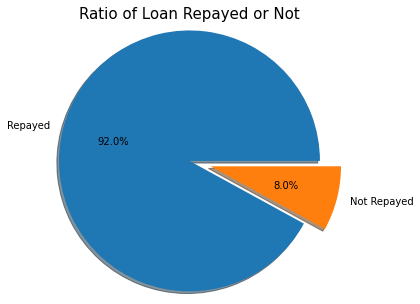

In [23]:
plt.figure(figsize=(12,5))

plt.pie(
    application.target.value_counts(),
    labels = ['Repayed','Not Repayed'], 
    explode = (0, 0.2),
    shadow=True,
    autopct='%1.1f%%',
    radius = 1.2
)

plt.title("Ratio of Loan Repayed or Not", fontsize = 15)
plt.show()

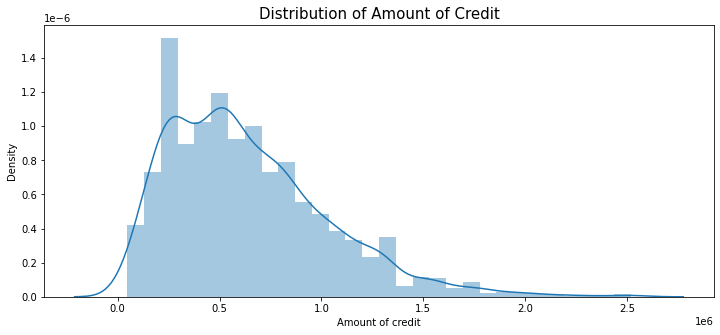

In [24]:
plt.figure(figsize=(12,5))

sns.distplot(application.amt_credit)

plt.title("Distribution of Amount of Credit", fontsize = 15)
plt.xlabel('Amount of credit')
plt.show()

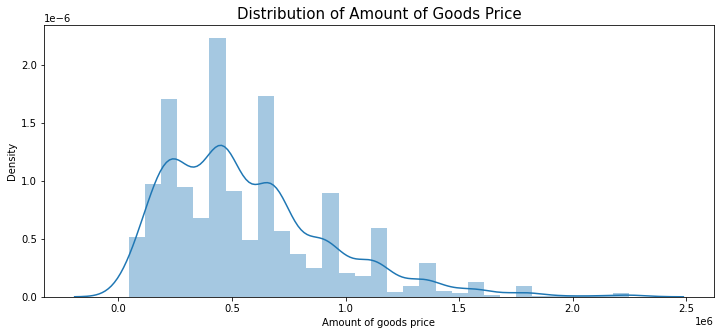

In [25]:
plt.figure(figsize=(12,5))

sns.distplot(application.amt_goods_price)

plt.title("Distribution of Amount of Goods Price", fontsize = 15)
plt.xlabel('Amount of goods price')
plt.show()

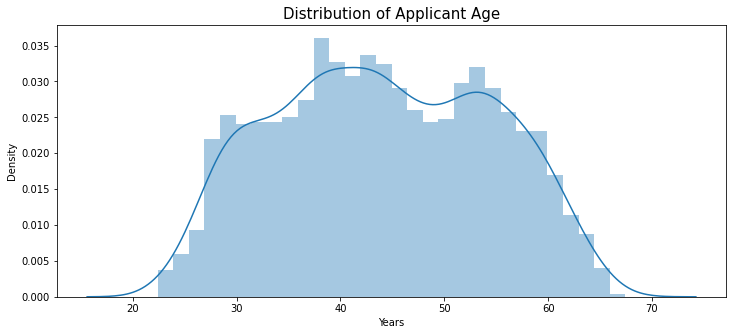

In [26]:
plt.figure(figsize=(12,5))

sns.distplot(application.days_birth / -365,bins = 30)

plt.title("Distribution of Applicant Age", fontsize = 15)
plt.xlabel('Years')
plt.show()

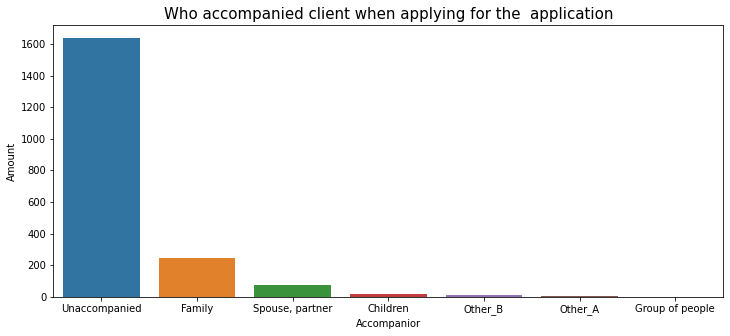

In [27]:
temp_df = application.name_type_suite.value_counts().reset_index()

plt.figure(figsize=(12,5))

sns.barplot(data = temp_df, x = 'index', y = 'name_type_suite')

plt.title("Who accompanied client when applying for the  application", fontsize = 15)
plt.xlabel('Accompanior')
plt.ylabel('Amount')
plt.show()

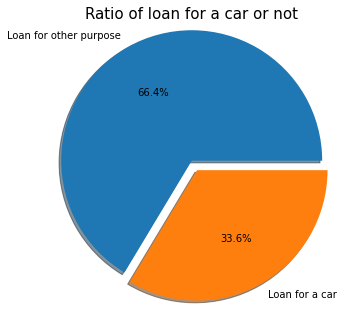

In [28]:
plt.figure(figsize=(12,5))

plt.pie(
    application.flag_own_car.value_counts(),
    labels = ['Loan for other purpose','Loan for a car'] ,
    explode = (0, 0.1),
    shadow = True,
    autopct = '%1.1f%%',
    radius = 1.2
)

plt.title("Ratio of loan for a car or not", fontsize = 15)
plt.show()

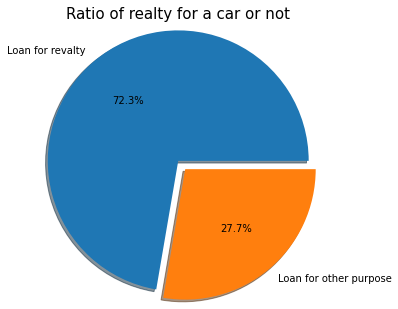

In [29]:
plt.figure(figsize=(12,5))

plt.pie(
    application.flag_own_realty.value_counts(),
    labels = ['Loan for revalty','Loan for other purpose'], 
    explode = (0, 0.1),
    shadow=True, 
    autopct='%1.1f%%',
    radius = 1.2
)

plt.title("Ratio of realty for a car or not", fontsize = 15)
plt.show()

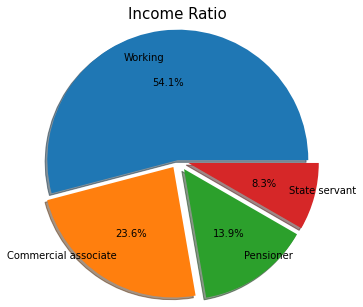

In [30]:
temp_df = application.name_income_type.value_counts()[:4]

plt.figure(figsize=(12,5))

plt.pie(
    temp_df,
    labels = temp_df[:4].index,
    explode = (0, 0.075,0.1,0.1), 
    shadow = True, 
    autopct = '%1.1f%%',
    labeldistance = 0.8,
    radius = 1.2
)

plt.title("Income Ratio", fontsize = 15)
plt.show()

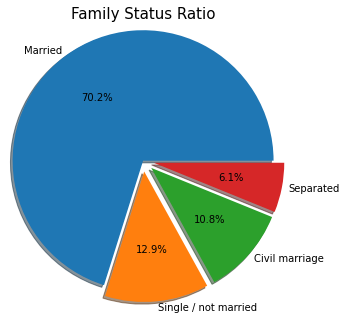

In [31]:
temp_df = application.name_family_status.value_counts()[:-1]

plt.figure(figsize=(12,5))

plt.pie(
    temp_df,
    labels = temp_df.index,
    explode = (0,0.1,0.1,0.1), 
    shadow = True, 
    autopct = '%1.1f%%',
    labeldistance = 1.05,
    radius = 1.2
)

plt.title("Family Status Ratio", fontsize = 15)
plt.show()

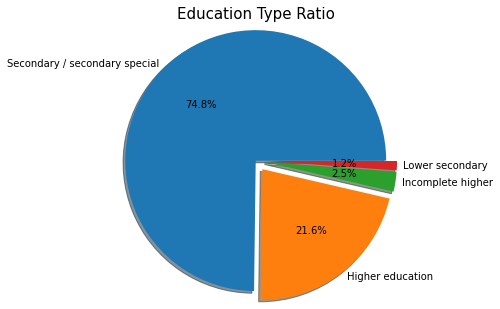

In [35]:
temp_df = application.name_education_type.value_counts()[:-1]

plt.figure(figsize=(12,5))

plt.pie(
    temp_df,
    labels = temp_df.index,
    explode = (0,0.1,0.1,0.1), 
    shadow = True, 
    autopct = '%1.1f%%',
    labeldistance = 1.05,
    radius = 1.2
)

plt.title("Education Type Ratio", fontsize = 15)
plt.show()


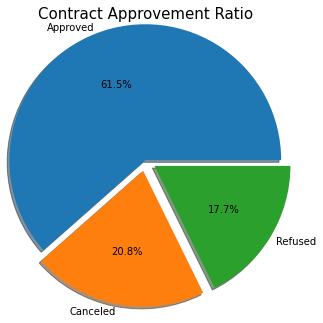

In [38]:
temp_df = previous_application.name_contract_status.value_counts()[:-1]

plt.figure(figsize=(12,5))

plt.pie(
    temp_df,
    labels = temp_df.index,
    explode = (0,0.1,0.1), 
    shadow = True, 
    autopct = '%1.1f%%',
    labeldistance = 1.05,
    radius = 1.25
)

plt.title("Contract Approvement Ratio", fontsize = 15)
plt.show()

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 02 </span>

In the next notebook we will generate a new data for Feature Groups